<a href="https://colab.research.google.com/github/Daria-Lytvynenko/ML_course/blob/main/HW_NLP_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Домашнє завдання: Побудова класифікатора сентименту на основі набору даних Tweet Sentiment Extraction

**Мета:** Провести аналіз набору даних, виконати векторизацію текстових даних за допомогою методів bag-of-words та TF-IDF, порівняти їх, побудувати класифікатор та провести аналіз помилок.

**Набір даних:**
Дані беремо з цього змагання на Kaggle: https://www.kaggle.com/competitions/tweet-sentiment-extraction/data?select=train.csv

Оригінальне змагання має дещо іншу задачу, але ми будемо поки будувати саме класифікатор.

### Завдання 1. Завантаження та ознайомлення з набором даних

- Завантажте набір даних `train.csv` з посилання та ознайомтеся з його структурою.
- Виведіть перші 5 рядків та основну статистику: кількість записів, типи колонок, кількість пропущених значень.
- Видаліть записи, в яких є пропущені значення.



In [53]:
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, roc_curve, auc, classification_report
from sklearn.tree import DecisionTreeClassifier
from nltk.tokenize import word_tokenize, PunktSentenceTokenizer
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords
import nltk
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [54]:
df = pd.read_csv('drive/MyDrive/ML_course/tweet_sentiment_train.csv/train.csv')

In [55]:
df.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [56]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27481 entries, 0 to 27480
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         27481 non-null  object
 1   text           27480 non-null  object
 2   selected_text  27480 non-null  object
 3   sentiment      27481 non-null  object
dtypes: object(4)
memory usage: 858.9+ KB


In [57]:
df.dropna(inplace=True)

### Завдання 2. Exploratory Data Analysis

- Проведіть аналіз кількості класів та розподілу міток. Класи знаходяться в колонці `sentiment`.
- Візуалізуйте розподіл довжин текстів в символах та зробіть висновок про довжини постів: якої довжини постів найбільше, що бачите з розподілу?



In [58]:
df.sentiment.value_counts(normalize=True)

,proportion
sentiment,
neutral,0.404549
positive,0.312300
negative,0.283151


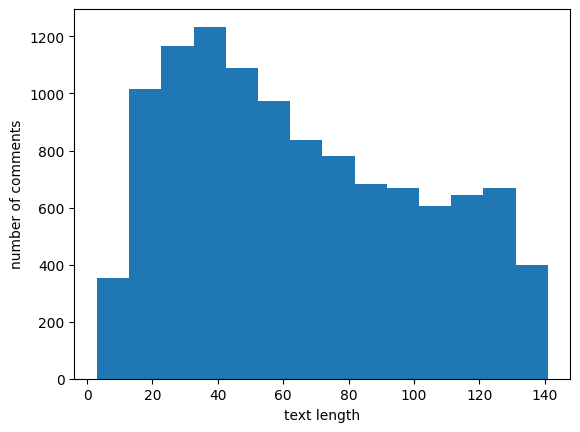

In [59]:
plt.hist(df[df.sentiment=='neutral']['text'].str.len(), bins=14)
plt.xlabel('text length')
plt.ylabel('number of comments');

Text(0.5, 1.0, 'negative')

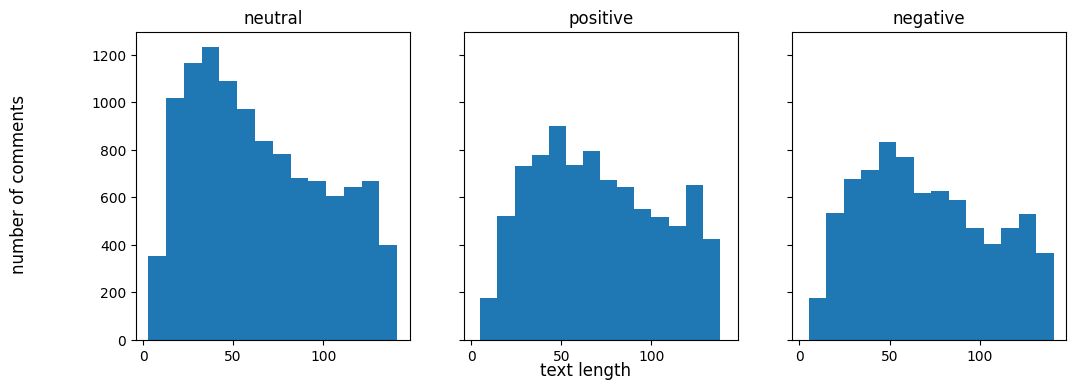

In [60]:
fig, ax=plt.subplots(nrows=1, ncols=3, figsize=(12,4), sharex=True, sharey=True)
fig.supxlabel('text length')
fig.supylabel('number of comments')
ax[0].hist(df[df.sentiment=='neutral']['text'].str.len(), bins=14)
ax[0].set_title('neutral')
ax[1].hist(df[df.sentiment=='positive']['text'].str.len(), bins=14)
ax[1].set_title('positive')
ax[2].hist(df[df.sentiment=='negative']['text'].str.len(), bins=14)
ax[2].set_title('negative')

Найбільше коментарів, що містять близько 40 символів, розподіл зміщений вліво. Якщо окремо дивитись по типу коментарів, то видно, для всіх груп розподіл подібний.

### Завдання 3. Попередня обробка текстових даних та векторизація з bag of words


Наша задача тут отримати вектори методом bag of words колонки `text`, виконавши попередню обробку тексту.
Попередня обробка має включати
- видалення stopwords необхідної мови
- токенізація (розбиття текстів на фрагменти по 1 слову)
- стеммінг слів зі `SnowballStemmer`.
- самостійно задайте кількість слів в словнику для `sklearn.feature_extraction.text.CountVectorizer`. Можливо для цього доведеться виконати додатковий аналіз.

Ви також можете додати сюди додаткові методи очистки текстів, наприклад, видалення деяких символів чи груп символів, якщо в процесі роботи побачите, що хочете щось видалити.

Напишіть код аби виконати це завдання. Перед цим рекомендую детально ознайомитись з тим, що робить обʼєкт `sklearn.feature_extraction.text.CountVectorizer` за замовченням.

Це завдання можна виконати двома способами - один - максимально подібно до того, як ми це робили в лекції, другий - дещо інакше перегрупувавши етапи обробки тексту.




In [61]:
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [62]:
detector=PunktSentenceTokenizer()

In [63]:
vect1=CountVectorizer()
vect_fit=vect1.fit(df['selected_text'])

In [64]:
vectors=vect1.transform(df['selected_text'])

In [65]:
select_text=vect1.get_feature_names_out()

In [66]:
vect=CountVectorizer()
vect_text=vect.fit(df['text'])
vectors_text=vect.transform(df['text'])

In [67]:
full_text=vect_text.get_feature_names_out()

In [68]:
diff=[i for i in full_text if i not in select_text and not i.startswith('_')]

In [69]:
diff

['00am',
 '00pm',
 '024',
 '02mxjj',
 '05ixbj',
 '0600',
 '06am',
 '07am',
 '07k6x',
 '07xfs',
 '07xoh',
 '07xoi',
 '097dfj',
 '0_o',
 '0ghz',
 '0guyoj',
 '0k',
 '0l2tsj',
 '0mqko',
 '0n',
 '0xhu5j',
 '1000th',
 '100greatestgames',
 '100msg',
 '101',
 '1017',
 '103',
 '1034415',
 '104m6wj',
 '106',
 '108',
 '1095',
 '10days',
 '10jsepj',
 '10k',
 '10mins',
 '10mm',
 '10ty',
 '10uemq',
 '110',
 '1100',
 '1115',
 '1123',
 '1130',
 '11w',
 '12am',
 '12f0y',
 '12k',
 '12lbs',
 '12p',
 '12r3c3',
 '12yr',
 '1313',
 '13341015518',
 '13576',
 '137cty',
 '13gigs',
 '13nfk1',
 '13th',
 '143',
 '147',
 '147heu',
 '14yr',
 '1500ft',
 '1505',
 '153bpm',
 '154upj',
 '15fo4x',
 '15h30',
 '15mins',
 '1638824',
 '1695368792',
 '16k',
 '16lbs',
 '16urvv',
 '16w6zv',
 '170',
 '1750',
 '1752876129',
 '177',
 '17again',
 '17cy61',
 '17th',
 '17zw1j',
 '180',
 '181',
 '182397',
 '1828x1556',
 '1864ml',
 '18aeg8',
 '18kwzh',
 '190',
 '1930',
 '1939',
 '1946',
 '1971',
 '1973',
 '1986',
 '1987',
 '1991',
 '19

In [70]:
df[df['text'].str.contains('_____')]

,textID,text,selected_text,sentiment
15922,366cc0d7ac,"_____ re:firmware. Heh, just a coincidence. I ...","re:firmware. Heh, just a coincidence. I didn`t...",neutral
16812,6ebce5c001,Peeps still here. Fun times. Gotta sleep tho. ...,Peeps still here. Fun times. Gotta sleep tho. ...,neutral
19484,e352e28416,"i really really hate biology , u______________...",hate biology,negative
26109,c02977bde0,**** IT!! _____________,**** IT!!,negative
26281,82cd0ad8a2,"Just bad day. T_____T Gyah. No car, baby-clie...",Just bad day.,negative


In [71]:
stemmer=SnowballStemmer(language='english')

In [72]:
nltk.download('stopwords')
english_stopwords=stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [73]:
english_stopwords=[i for i in english_stopwords if i not in ["aren't",'couldn',
 "couldn't",'didn',
 "didn't", 'doesn',
 "doesn't",'don',
 "don't",'hadn',
 "hadn't",'hasn',
 "hasn't",'haven',
 "haven't", 'isn',
 "isn't",'mightn',
 "mightn't",'needn',
 "needn't",'no',
 'not','shan',
 "shan't",'shouldn',
 "shouldn't",'wasn',
 "wasn't",'weren',
 "weren't","won't",
 'wouldn',
 "wouldn't",]]

In [74]:
def tokenize(text):
  return [stemmer.stem(word) for word in word_tokenize(text) if word not in english_stopwords]

In [75]:
vectorizer=CountVectorizer(lowercase=True,
                           tokenizer=tokenize,
                           stop_words=english_stopwords,
                           max_features=10000)


In [76]:
vectorizer.fit(df['selected_text'])

/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'d", "'m", "'s", 'must', "n't"] not in stop_words.
  warnings.warn(


CountVectorizer(max_features=10000,
                stop_words=['a', 'about', 'above', 'after', 'again', 'against',
                            'ain', 'all', 'am', 'an', 'and', 'any', 'are',
                            'aren', 'as', 'at', 'be', 'because', 'been',
                            'before', 'being', 'below', 'between', 'both',
                            'but', 'by', 'can', 'd', 'did', 'do', ...],
                tokenizer=<function tokenize at 0x7f9623270180>)

In [77]:
inputs=vectorizer.transform(df['selected_text'])

In [78]:
inputs.shape

(27480, 10000)

### Завдання 4. Побудова класифікатора

- Розділіть індекси даних на навчальний та тестовий набори в обраному співвівдношенні. Використовуючи отримані індекси сфомуйте набори для тренування класифікатора `X_train_bow, X_test_bow, y_train, y_test`.
- Навчіть класифікатор (наприклад, Logistic Regression, Decision Tree або один з алгоритмів бустингу) на даних, векторизованих методом bag-of-words. Спробуйте кілька моделей і оберіть найбільш точну :)
- Виведіть інформацію, яка дає можливість оцінити якість класифікації.
- Оцініть якість фінальної класифікації: вона хороша чи не дуже?



In [79]:
train_idx, test_idx=train_test_split(range(inputs.shape[0]), test_size=0.3, random_state=42)

In [80]:
X_train_bow=inputs[train_idx]
X_test_bow=inputs[test_idx]
y_train=df.iloc[train_idx, -1]
y_test=df.iloc[test_idx, -1]

In [81]:
logreg=LogisticRegression(solver='saga', penalty='l1')

In [82]:
def predictions(model, train_input, test_input, train_target, test_target):
  model.fit(train_input, train_target)
  pred=model.predict(test_input)
  accuracy=accuracy_score(test_target, pred)
  f1=f1_score(test_target, pred, average='weighted')
  confusion_m=confusion_matrix(test_target, pred)
  print(f'accurracy score for test dataset : {accuracy}\nf1_score for test dataset : {f1}\nconfusion matrix\n{confusion_m}' )

In [83]:
predictions(logreg, X_train_bow, X_test_bow, y_train, y_test)

accurracy score for test dataset : 0.7848131974769529
f1_score for test dataset : 0.784414238675285
confusion matrix
[[1700  485  171]
 [ 322 2783  238]
 [ 215  343 1987]]


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [84]:
tree=DecisionTreeClassifier(splitter='best', random_state=42, max_depth=1000)

In [85]:
predictions(tree, X_train_bow, X_test_bow, y_train, y_test)

accurracy score for test dataset : 0.7395681707908782
f1_score for test dataset : 0.7397794276484033
confusion matrix
[[1830  372  154]
 [ 632 2279  432]
 [ 293  264 1988]]


In [86]:
forest=RandomForestClassifier(n_estimators=200, max_depth=1000, random_state=42)

In [87]:
predictions(forest, X_train_bow, X_test_bow, y_train, y_test)

accurracy score for test dataset : 0.7996118389131489
f1_score for test dataset : 0.7999398575930676
confusion matrix
[[1846  382  128]
 [ 382 2682  279]
 [ 233  248 2064]]


In [88]:
lgbmodel=lgb.LGBMClassifier(max_depth=100, n_estimators=500, learning_rate=0.1)

In [89]:
X_train_bow=X_train_bow.astype(np.float32)
X_test_bow=X_test_bow.astype(np.float32)

In [90]:
predictions(lgbmodel, X_train_bow, X_test_bow, y_train, y_test)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.162533 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1761
[LightGBM] [Info] Number of data points in the train set: 19236, number of used features: 646
[LightGBM] [Info] Start training from score -1.265766
[LightGBM] [Info] Start training from score -0.905999
[LightGBM] [Info] Start training from score -1.158876


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


accurracy score for test dataset : 0.8007035419699176
f1_score for test dataset : 0.801501831886734
confusion matrix
[[1900  350  106]
 [ 385 2738  220]
 [ 338  244 1963]]


In [91]:
pred_test=pd.concat([y_test.reset_index(drop=True), pd.Series(logreg.predict(X_test_bow), name='pred_class'), pd.DataFrame(logreg.predict_proba(X_test_bow),
                                                                                                                           columns=['neg', 'neutr', 'pos']),
                      pd.Series(np.max(logreg.predict_proba(X_test_bow), axis=1), name='max_proba')], axis=1)

In [92]:
pred_test

,sentiment,pred_class,neg,neutr,pos,max_proba
0,positive,positive,0.157583,0.214552,0.627866,0.627866
1,negative,negative,0.368749,0.305357,0.325893,0.368749
2,neutral,neutral,0.369469,0.382587,0.247944,0.382587
3,positive,positive,0.310253,0.250587,0.439160,0.439160
4,neutral,negative,0.351590,0.304546,0.343864,0.351590
...,...,...,...,...,...,...
8239,positive,positive,0.014917,0.043829,0.941254,0.941254
8240,neutral,neutral,0.074475,0.922831,0.002694,0.922831
8241,positive,positive,0.014802,0.080334,0.904864,0.904864
8242,negative,negative,0.832036,0.109085,0.058880,0.832036


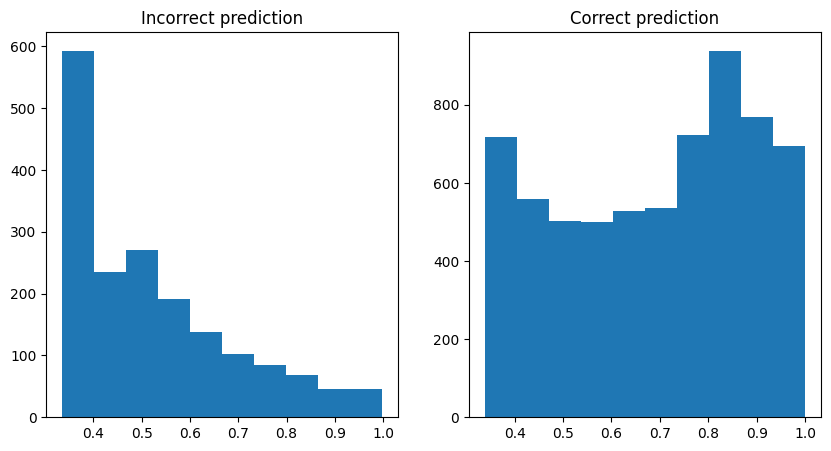

In [93]:
fig, ax=plt.subplots(nrows=1, ncols=2, figsize=(10,5))
ax[0].hist(pred_test[pred_test['sentiment']!=pred_test['pred_class']]['max_proba'])
ax[0].set_title('Incorrect prediction')
ax[1].hist(pred_test[pred_test['sentiment']==pred_test['pred_class']]['max_proba'])
ax[1].set_title('Correct prediction')
fig.show()

Значення метрики f1 на тестових даних 67,5%. Модель не дуже точна. З матриці видно, що модель багато зразків невірно відносить до нейтрального класу. З графіків розподілу ймовірностей видно, що на неправильно передбачених зразках модель не дуже впевнена і багато ймовірностей лежить в діапазоні 0.34-0.5, тоді як менше значень в дапазоні 0.7-1.0. Хоча і серед правильних передбачень велика к-сть зразків з ймовірністю до 0.5.

### Завдання 5. Аналіз впливовості слів в отриманого класифікатора

- Для обраної вами моделі проведіть аналіз важливості слів (ознак): які слова (токени) найбільше впливають для визначення сентименту? Чи це логічно на ваш погляд, що саме ці символи впливають найбільше/найменще?


In [94]:
feat_importance=pd.DataFrame(logreg.coef_[0], index=vectorizer.get_feature_names_out(), columns=['imp'])

In [95]:
valuable_words=pd.concat([pd.DataFrame(feat_importance.sort_values(by='imp', ascending=True)[:30]).reset_index(drop=False),
                            pd.DataFrame(feat_importance.sort_values(by='imp', ascending=False)[:30]).reset_index(drop=False)], axis=1)

In [96]:
valuable_words

,index,imp,index,imp
0,love,-1.279509,miss,1.460831
1,thank,-1.067869,sad,1.408288
2,happi,-0.898514,sorri,1.204644
3,hope,-0.894024,suck,1.199331
4,good,-0.878478,hate,1.165033
5,great,-0.795308,bore,1.002082
6,awesom,-0.774663,bad,0.959385
7,nice,-0.689354,hurt,0.949889
8,lol,-0.661094,sick,0.931663
9,better,-0.551211,not,0.801951


Загалом, перелік важливих слів виглядає логічно.

### Завдання 6. Векторизація текстів з допомогою TF-IDF. Тренування класифікатора, аналіз точності і впливовості слів.

- Проведіть векторизацію текстів з векторизатором TfidfVectorizer. Реалізуйте векторизацію так, аби препроцесинг включав всі ті самі кроки, що і в випадку використання векторизації Bag of Words.

- Натренуйте той самий класифікатор на TF-IDF векторах, виконавши розбивку набору даних на train, test так, аби в трейні були всі ті самі записи, що і були в попередньому завданні (це важливо для порівняння результатів).

- Проаналізуйте якість класифікації вивівши потрібні для цього метрики. Чи стала якість класифікації кращою?

- Які токени найбільше впливають на результат при тренуваннні класифікатора з TF-IDF векторами? Порівняйте з найважливішими токенами при Bag of Words векторизації. Яку векторизацію ви б обрали для фінальної імплементації рішення? Обґрунтуйте свій вибір.



In [97]:
tfidf=TfidfVectorizer(lowercase=True,
                           tokenizer=tokenize,
                           stop_words=english_stopwords,
                           max_features=10000)

In [98]:
tfidf.fit(df['selected_text'])

/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'d", "'m", "'s", 'must', "n't"] not in stop_words.
  warnings.warn(


TfidfVectorizer(max_features=10000,
                stop_words=['a', 'about', 'above', 'after', 'again', 'against',
                            'ain', 'all', 'am', 'an', 'and', 'any', 'are',
                            'aren', 'as', 'at', 'be', 'because', 'been',
                            'before', 'being', 'below', 'between', 'both',
                            'but', 'by', 'can', 'd', 'did', 'do', ...],
                tokenizer=<function tokenize at 0x7f9623270180>)

In [99]:
input_tfidf=tfidf.transform(df['selected_text'])

In [100]:
X_train_tfidf=input_tfidf[train_idx]
X_test_tfidf=input_tfidf[test_idx]

In [101]:
logreg=LogisticRegression(solver='saga', penalty='l1')

In [102]:
predictions(logreg, X_train_tfidf, X_test_tfidf, y_train, y_test)

accurracy score for test dataset : 0.8136826783114993
f1_score for test dataset : 0.8140851801171592
confusion matrix
[[1827  465   64]
 [ 318 2847  178]
 [ 191  320 2034]]


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [103]:
feat_importance=pd.DataFrame(logreg.coef_[0], index=tfidf.get_feature_names_out(), columns=['imp'])

In [104]:
valuable_words=pd.concat([pd.DataFrame(feat_importance.sort_values(by='imp', ascending=True)[:30]).reset_index(drop=False),
                            pd.DataFrame(feat_importance.sort_values(by='imp', ascending=False)[:30]).reset_index(drop=False)], axis=1)

In [105]:
valuable_words.columns=['pos_words', 'min_imp', 'neg_words', 'max_imp']

In [106]:
valuable_words

,pos_words,min_imp,neg_words,max_imp
0,lol,-7.372056,stupid,6.010528
1,awesom,-5.419283,suck,5.760855
2,haha,-5.265420,fail,5.561128
3,hope,-5.039241,worst,5.555152
4,love,-4.221808,miss,5.352925
5,thank,-4.047483,sad,5.272986
6,final,-3.725324,hate,5.143352
7,glad,-3.473082,bore,5.098995
8,hehe,-3.452777,wors,4.803849
9,better,-3.400726,wtf,4.570616


In [107]:
forest=RandomForestClassifier(n_estimators=200, max_depth=1000, random_state=42)

In [108]:
predictions(forest, X_train_tfidf, X_test_tfidf, y_train, y_test)

accurracy score for test dataset : 0.8095584667637069
f1_score for test dataset : 0.8094625537580562
confusion matrix
[[1790  465  101]
 [ 290 2921  132]
 [ 231  351 1963]]


In [109]:
ovo=OneVsOneClassifier(estimator=LinearSVC(C=0.3, random_state=42))

In [110]:
predictions(ovo, X_train_tfidf, X_test_tfidf, y_train, y_test)

accurracy score for test dataset : 0.8298156234837457
f1_score for test dataset : 0.8300833904165152
confusion matrix
[[1856  432   68]
 [ 284 2899  160]
 [ 154  305 2086]]


In [111]:
lgbmodel=lgb.LGBMClassifier(max_depth=100, n_estimators=500, learning_rate=0.1)

In [112]:
predictions(lgbmodel, X_train_tfidf, X_test_tfidf, y_train, y_test)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.086310 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 19919
[LightGBM] [Info] Number of data points in the train set: 19236, number of used features: 646
[LightGBM] [Info] Start training from score -1.265766
[LightGBM] [Info] Start training from score -0.905999
[LightGBM] [Info] Start training from score -1.158876


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


accurracy score for test dataset : 0.8019165453663271
f1_score for test dataset : 0.8023878899964517
confusion matrix
[[1881  379   96]
 [ 357 2788  198]
 [ 309  294 1942]]


### Завдання 7. Аналіз помилок класифікації з векторизацією TF-IDF.

- Проаналізуйте, на яких екземплярах помиляється класифікатор при векторизації TF-IDF.
- На основі аналізу запропонуйте 3 шляхи поліпшення якості класифікації.

In [113]:
pred_test=pd.concat([y_test.reset_index(drop=True), pd.Series(logreg.predict(X_test_tfidf), name='pred_class'), pd.DataFrame(logreg.predict_proba(X_test_tfidf),
                                                                                                                             columns=['neg', 'neutr', 'pos']),
                      pd.Series(np.max(logreg.predict_proba(X_test_tfidf), axis=1), name='max_proba')], axis=1)

In [114]:
predictions=pd.concat([df[['selected_text','text']].iloc[test_idx,:].reset_index(drop=True), pred_test], axis=1)

In [115]:
predictions[predictions['sentiment']!=predictions['pred_class']]

,selected_text,text,sentiment,pred_class,neg,neutr,pos,max_proba
1,kinda turns me off,--of them kinda turns me off of it all. And ...,negative,neutral,0.303873,0.487536,0.208591,0.487536
7,t I have an exam on the monday that Im gonna fail,"Ooooh, I`m jealous I might try and get some ...",negative,neutral,0.411357,0.578145,0.010499,0.578145
21,I wish I had company,I wish I had company,negative,positive,0.145068,0.218992,0.635940,0.635940
23,time to celebrate an,Today is check in day for week 12 of the Artis...,positive,neutral,0.196479,0.412758,0.390762,0.412758
25,I wish I could go,I wish I could go. See ya at Warped for sure...,positive,neutral,0.106767,0.625228,0.268005,0.625228
...,...,...,...,...,...,...,...,...
8209,Getting dizzy. Going to have to lower my origi...,Getting dizzy. Going to have to lower my ori...,negative,neutral,0.308150,0.601663,0.090187,0.601663
8218,please don`t,please don`t,neutral,negative,0.537864,0.260253,0.201883,0.537864
8222,"boredd,","juss boredd, !",negative,neutral,0.261222,0.520475,0.218303,0.520475
8234,Greenville Drive games just aren`t the same wi...,Greenville Drive games just aren`t the same wi...,negative,neutral,0.199188,0.732732,0.068080,0.732732


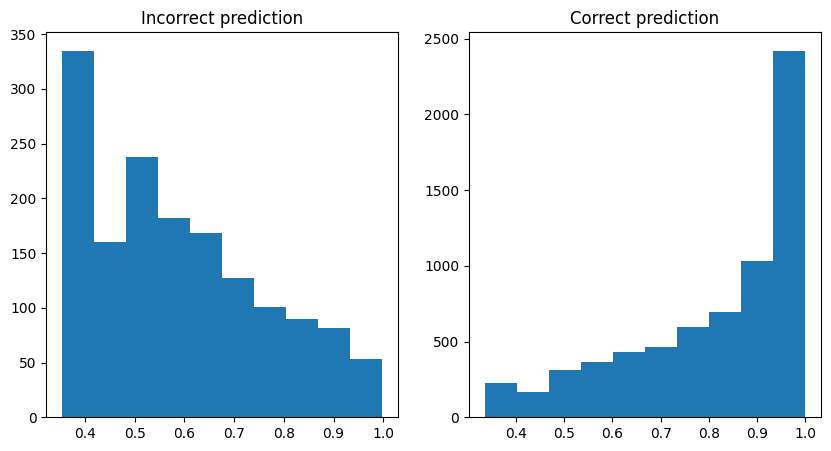

In [116]:
fig, ax=plt.subplots(nrows=1, ncols=2, figsize=(10,5))
ax[0].hist(pred_test[pred_test['sentiment']!=pred_test['pred_class']]['max_proba'])
ax[0].set_title('Incorrect prediction')
ax[1].hist(pred_test[pred_test['sentiment']==pred_test['pred_class']]['max_proba'])
ax[1].set_title('Correct prediction')
fig.show()

Спочатку я будувала моделі на основі колонки df.text, значення f1 та accuracy були приблизно на 10% менше за ті, що отримані при побудові моделі на основі df.selected_text, оскільки в даній колонці винесені словосполучення, які впливають на розподіл коментарів на позитивні, нейтральні та негативні. Також я видалила з переліку стоп-слів частки "не", оскільки в деяких випадках вони змінювали тон коментаря на протилежний. Це підвищило метрики приблизно на 1%. Найкращий результат дала модель OneVsOneClassifier, можливо, через те, що при бінарній класифікації краще розділились класи нейтральний та негативний і нейтральний та позитивний, оскільки в таблиці з неправильно класифікованими зразками на основі логістичної регресії було багато зразків з ймовірністю близько 0.4 і можна сказати, що модель була не дуже вневнена в прогнозах. І з матриці видно, що при використанні OneVsOneClassifier менше зразків були помилково віднесені до нейтрального класу, ніж при використанні дерев та логістичної регресії.

І на фінал кернел для натхнення і ознайомлення з рішенням оригінальної задачі. Багато цікавих візуалізацій і аналізу є тут, а також тут розвʼязується саме проблема named entitty recognition і можна ознайомитись як це робиться - вона дещо складніша по своїй суті ніж класифікація, подумайте, чому:

https://www.kaggle.com/code/tanulsingh077/twitter-sentiment-extaction-analysis-eda-and-model